In [1]:
"""Make photon transfer functions."""

import os
import sys
import time
from tqdm import tqdm
import argparse

import numpy as np

from low_energy.lowE_electrons import make_interpolator
from low_energy.lowE_deposition import compute_fs

sys.path.append("..")
from dm21cm.utils import load_h5_dict
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from   darkhistory.spec.spectrum import Spectrum
import darkhistory.physics as dh_phys
import darkhistory.spec.spectools as spectools

In [2]:
run_name = 'zf01'
tf_type = 'phot'
do_not_track_lowengphot = True
include_f_xray = True
xray_eng_range = (1e2, 1e4) # [eV]
use_tqdm = True
verbose = 0 # {0, 1}
stop_after_n = np.inf


#===== Load =====
data_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/{run_name}/{tf_type}"
save_dir = f"{os.environ['DM21CM_DATA_DIR']}/tf/{run_name}/{tf_type}"
os.makedirs(save_dir, exist_ok=True)

print('Loading tf: ', end=' ', flush=True)
hep_tfgv = np.load(f'{data_dir}/hep_tf_rxneo.npy')
print('hep', end=' ', flush=True)
lep_tfgv = np.load(f'{data_dir}/lep_tf_rxneo.npy')
print('lep', end=' ', flush=True)
lee_tfgv = np.load(f'{data_dir}/lee_tf_rxneo.npy')
print('lee', end=' ', flush=True)
hed_tfgv = np.load(f'{data_dir}/hed_tf_rxneo.npy')
print('hed', end=' ', flush=True)
cmbloss_gv = np.load(f'{data_dir}/cmbloss_rxneo.npy')
print('cmb', end=' ', flush=True)
dts = np.load(f'{data_dir}/dt_rxneo.npy')
print('dt',  end='.', flush=True)

Loading tf:  hep lep lee hed cmb dt.

In [3]:
#===== Initialize =====
abscs = load_h5_dict(f"../data/abscissas/abscs_{run_name}.h5")
dlnz = abscs['dlnz']
inj_abscs = abscs['photE'] if tf_type == 'phot' else abscs['elecEk'] + dh_phys.me
i_xray_fm = np.searchsorted(abscs['photE'], xray_eng_range[0])
i_xray_to = np.searchsorted(abscs['photE'], xray_eng_range[1])
MEDEA_interp = make_interpolator(prefix='../data/MEDEA')

tfgv = np.zeros_like(hep_tfgv) # in: elec/phot, out: phot
depgv = np.zeros(
    hed_tfgv.shape[:-1] + (len(abscs['dep_c']),)
) # channels: {H ionization, He ionization, excitation, heat, continuum, xray}


#===== Loop =====
n_run = -1

In [4]:
i_rs = 5
rs = abscs['rs'][i_rs]

i_x = 4
x = abscs['x'][i_x]

i_nBs = 6
nBs = abscs['nBs'][i_nBs]

    
#===== Timestepping =====
# We will always assume ionhist (IDL) uses the 21cmFAST's dt. This will be fixed in ionhist.
dlnz = abscs['dlnz']
zplusone_factor = np.exp(dlnz)
dt = phys.dt_step(rs-1, zplusone_factor) # 21cmFAST dt
# dt = dlnz / dh_phys.hubble(rs) # DH dt
# dt = dts[i_rs, 1] # (rs, step) # IDL dt

#===== Add cmbloss to highengphot =====
cmb_un = spectools.discretize(abscs['photE'], dh_phys.CMB_spec, dh_phys.TCMB(rs))
cmb_un_E = cmb_un.toteng()
    
for i in range(len(inj_abscs)):
    cmb_E = cmbloss_gv[i_rs, i_x, i_nBs][i]# * dt # now [eV/Bavg]
    hep_tfgv[i_rs, i_x, i_nBs][i] += (-cmb_E/cmb_un_E) * cmb_un.N

#===== Add lowengphot diagonal =====
if tf_type == 'phot':
    for i in range(len(inj_abscs)):
        if lep_tfgv[i_rs, i_x, i_nBs][i][i] > 1e-40:
            break
        lep_tfgv[i_rs, i_x, i_nBs][i][i] = 1.

In [6]:
for i_injE, injE in enumerate(inj_abscs):
    
    assert n_run <= stop_after_n
    n_run += 1

    #===== Injection =====
    # inject one photon at i_injE
    timer = time.time()
    
    hep_spec_N = hep_tfgv[i_rs, i_x, i_nBs, i_injE]
    lep_spec_N = lep_tfgv[i_rs, i_x, i_nBs, i_injE]
    lee_spec_N = lee_tfgv[i_rs, i_x, i_nBs, i_injE]
    hed_arr    = hed_tfgv[i_rs, i_x, i_nBs, i_injE]

    lowengelec_spec_at_rs = Spectrum(abscs['elecEk'], lee_spec_N, spec_type='N')
    lowengelec_spec_at_rs.rs = rs

    lowengphot_spec_at_rs = Spectrum(abscs['photE'], lep_spec_N, spec_type='N')
    lowengphot_spec_at_rs.rs = rs

    highengdep_at_rs = hed_arr / dt # [eV/Bavg/s]

    #===== Compute f's =====
    x_vec_for_f = np.array( [1-x, dh_phys.chi*(1-x), dh_phys.chi*x] ) # [HI, HeI, HeII]/nH
    nBs_ref = 1
    dE_dVdt_inj = injE * dh_phys.nB * nBs_ref * rs**3 / dt # [eV/cm^3 s]
    # in DH.main: (dN_inj/dB) / (dE_inj  /dVdt)
    # here:       (dN_inj   ) / (dE_injdB/dVdt)
    f_low, f_high = compute_fs(
        MEDEA_interp=MEDEA_interp,
        rs=rs,
        x=x_vec_for_f,
        elec_spec=lowengelec_spec_at_rs,
        phot_spec=lowengphot_spec_at_rs,
        dE_dVdt_inj=dE_dVdt_inj,
        dt=dt,
        highengdep=highengdep_at_rs,
        cmbloss=0, # turned off in darkhistory main as well
        method='no_He',
        cross_check=False,
        ion_old=False
    )
    f_raw = f_low + f_high

    #===== Compute tf & f values =====
    f_dep = f_raw
    if do_not_track_lowengphot:
        phot_spec_N = hep_spec_N
        f_prop = np.dot(abscs['photE'], phot_spec_N) / injE
    else:
        i_exc_bin = np.searchsorted(spectools.get_bin_bound(abscs['photE']), 10.2) - 1 # 149
        lep_prop_spec_N = lep_spec_N.copy()
        lep_prop_spec_N[:i_exc_bin] *= 0.
        f_lep_prop = np.dot(abscs['photE'], lep_prop_spec_N) / injE
        phot_spec_N = hep_spec_N + lep_prop_spec_N
        f_dep[4] -= f_lep_prop # adjust for the propagating lowengphot

    f_prop = np.dot(abscs['photE'], phot_spec_N) / injE
    f_tot = f_prop + np.sum(f_dep)

    #===== Fix energy conservation (known issues) =====
    if i_injE == 153: # issue at around 13.6 eV. Adjusting H_ion.
        f_dep[0] += 1 - f_tot

    f_prop = np.dot(abscs['photE'], phot_spec_N) / injE
    f_tot = f_prop + np.sum(f_dep)

    #===== Energy conservation =====
    f_dep_str = ' '.join([f'{v:.3e}' for v in f_dep])
    print_str = f'{n_run} | {i_rs} {i_x} {i_nBs} {i_injE} | f_prop={f_prop:.6f} f_dep={f_dep_str} f_tot={f_tot:.6f}'
    energy_conservation_threshold = 1e-3
    if np.abs(f_tot - 1.) > energy_conservation_threshold:
        print_str += f' | Energy error > {energy_conservation_threshold}'
    if verbose >= 1 or np.abs(f_tot - 1.) > energy_conservation_threshold:
        print(print_str, flush=True)
    
    # enforce energy conservation
    phot_spec_N[i_injE] += 1 - f_tot # gives all extra energy to propagating photons
    
    #===== Dependent variables (Xray) =====
    if include_f_xray:
        f_xray = np.dot(abscs['photE'][i_xray_fm:i_xray_to], phot_spec_N[i_xray_fm:i_xray_to]) / injE
        # if i_xray_fm <= i_injE and i_injE < i_xray_to:
        #     f_xray -= phot_spec_N[i_injE] # ignore diagonal for now # NEED TO EXTRACT PROP
        f_dep = np.append(f_dep, f_xray)
        if f_xray > 0.001:
            print(f'i={i_injE} f_xray={f_xray:.6f}')

    #===== Populate transfer functions =====
    tfgv[i_rs, i_x, i_nBs, i_injE] = phot_spec_N
    depgv[i_rs, i_x, i_nBs, i_injE] = f_dep

i=202 f_xray=0.352328
i=203 f_xray=0.495962
i=204 f_xray=0.608012
i=205 f_xray=0.695353
i=206 f_xray=0.763383
i=207 f_xray=0.816333
i=208 f_xray=0.857517
i=209 f_xray=0.889528
i=210 f_xray=0.914393
i=211 f_xray=0.933696
i=212 f_xray=0.948672
i=213 f_xray=0.960284
i=214 f_xray=0.969283
i=215 f_xray=0.976253
i=216 f_xray=0.981648
i=217 f_xray=0.985823
i=218 f_xray=0.989052
i=219 f_xray=0.991548
i=220 f_xray=0.993476
i=221 f_xray=0.994965
i=222 f_xray=0.996115
i=223 f_xray=0.996992
i=224 f_xray=0.997816
i=225 f_xray=0.998141
i=226 f_xray=0.998570
i=227 f_xray=0.998987
i=228 f_xray=0.999167
i=229 f_xray=0.999313
i=230 f_xray=0.999521
i=231 f_xray=0.999617
i=232 f_xray=0.999659
i=233 f_xray=0.999761
i=234 f_xray=0.999809
i=235 f_xray=0.999819
i=236 f_xray=0.999865
i=237 f_xray=0.999886
i=238 f_xray=0.999890


In [25]:
data_dir = os.environ['DM21CM_DATA_DIR'] + '/tf/zf01-nopropxray/data'

In [8]:
import h5py

In [26]:
with h5py.File(data_dir+'/phot_dep.h5', 'r') as hf:
    axes = hf['axes'][()]
    dep_tf = hf['data'][()]

In [20]:
abscs['dep_c']

array([b'H ion', b'He ion', b'exc', b'heat', b'cont', b'xray'],
      dtype=object)

In [23]:
import matplotlib.pyplot as plt

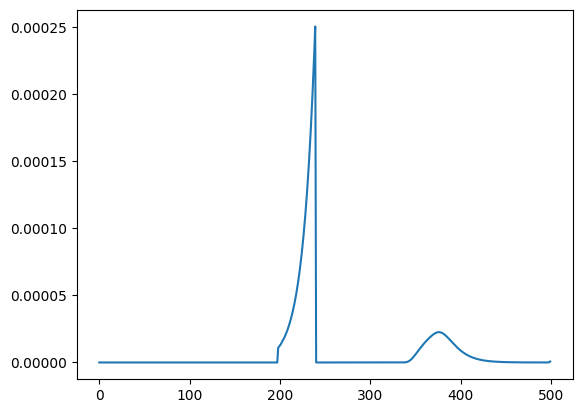

In [27]:
plt.plot(dep_tf[3, :, 4, 5, -1] / abscs['photE'])

In [28]:
with h5py.File(data_dir+'/phot_scat.h5', 'r') as hf:
    axes = hf['axes'][()]
    scat_tf = hf['data'][()]

In [32]:
ilo = np.searchsorted(abscs['photE'], 1e2)
ihi = np.searchsorted(abscs['photE'], 1e4)

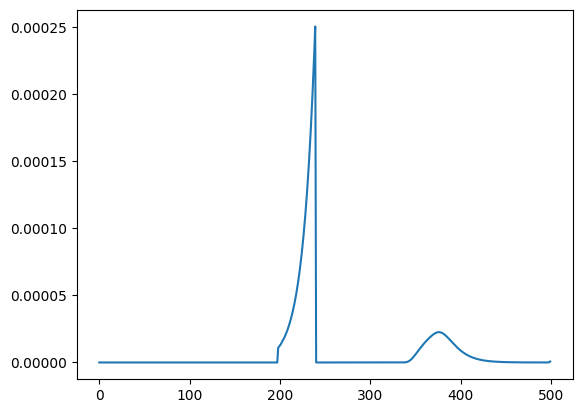

In [33]:
plt.plot(np.einsum('ij,j->i', scat_tf[3, :, 4, 5, ilo:ihi], abscs['photE'][ilo:ihi]) / abscs['photE'])